In [39]:
import numpy as np
from slsim.Util.param_util import random_radec_string
from slsim.LsstSciencePipeline.lsst_science_pipeline import dp0_time_series_images_data
from slsim.LsstSciencePipeline.util_lsst import multiple_variable_lens_injection
import lsst.daf.butler as dafButler
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.plot_functions import create_image_montage_from_image_list
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.Sources.point_sources import PointSources
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate

## Injection of variable lenses in dp0.2 data

This notebook shows how to use SLSim to simulate variable lens images and inject them to

 dp0.2 data.

It involves three steps:
1. Create a time series data from dp0 data using SLSim.
2. Based on the created time series data, simulate variable lenses using SLSim.
3. Finally, inject variable lenses to time series data.

## Create a time series data

In [2]:
config = "dp02"
collection = "2.2i/runs/DP0.2"
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

In [4]:
radec_string = random_radec_string(ra_min=55, ra_max=70, dec_min=-43, dec_max=-30, n=5)

In [5]:
expo_data_list = []
for center_coords in radec_string:
    expo_data_list.append(
        dp0_time_series_images_data(
            butler, center_coords, radius="0.034", band="i", size=301
        )
    )

## Define a tranform matrices for each exposure

Here we use the same tranform matrices for each exposure but they can be different for 

each exposure based on observational conditions.

In [6]:
transf_matrix_single = np.array([[0.2, 0], [0, 0.2]])
transform_matrices_list = []
for data in expo_data_list:
    transform_matrices_list.append(
        [transf_matrix_single.copy() for _ in range(len(data))]
    )

## Simulate lens population

In [19]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
sky_area = Quantity(value=1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 23, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

In [20]:
# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

In [26]:
# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

/home/mialamontagne/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/home/mialamontagne/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [27]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

In [28]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}
# Initiate source population class.
quasars = PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=sky_area,
    kwargs_cut=kwargs_source_cut,
    pointsource_type="quasar",
    **kwargs_quasar
)

In [29]:
# run skypy pipeline and make galaxy-galaxy population class using LensPop
lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=quasars,
    sky_area=sky_area,
    cosmo=cosmo,
)

## Select lenses for each time series data

In [30]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class_list = []
for i in range(len(expo_data_list)):
    lens_class_list.append(lens_pop.select_lens_at_random(**kwargs_lens_cut))

## Inject lenses to time series data

In [37]:
variable_lens_catalog = multiple_variable_lens_injection(
    lens_class_list,
    band="i",
    num_pix=301,
    transform_matrices_list=transform_matrices_list,
    exposure_data_list=expo_data_list,
)

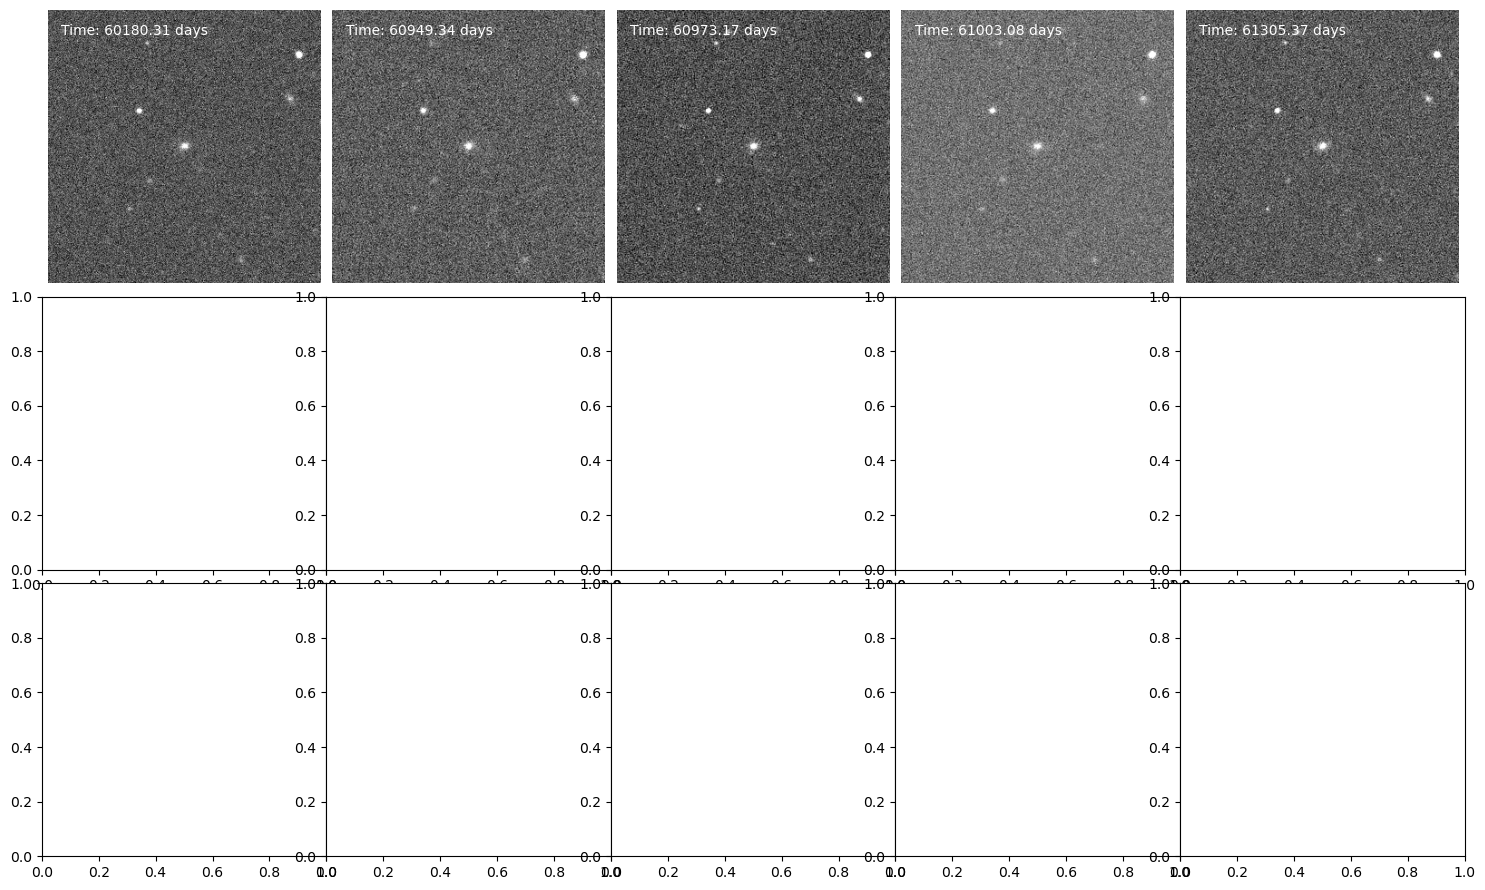

In [35]:
##plot each injected lens
plot_variable_lenses = create_image_montage_from_image_list(
    num_rows=3,
    num_cols=5,
    images=variable_lens_catalog[0]["injected_lens"],
    time=variable_lens_catalog[0]["obs_time"],
    image_type="dp0",
)